# PROBLEM

In this knowledge adventure we will learn many thing while trying to create a computer vision system that classify "3"s or "7"s from the known MNIST dataset.

In [1]:
!pip list | grep fastbook

fastbook                 0.0.29


In [2]:
import random

In [3]:
import pandas as pd

In [172]:

from fastai.basics import torch, tensor, plt, SGD, L
from fastai.vision.all import (
    matplotlib,
    untar_data,
)
from fastai.vision.widgets import Image, show_image
from fastbook import (
    DataLoader,
    DataLoaders,
    first,
    Path,
    Learner,
    URLs,
)

matplotlib.rc("image", cmap="Greys")

## DATASET

In [5]:
dest_dataset = "/home/david/ML_DL/datasets/mini_mnist/"
path = untar_data(URLs.MNIST_SAMPLE, dest_dataset)

In [6]:
Path.BASE_PATH = path

In [7]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [8]:
(path/"train").ls()

(#2) [Path('train/7'),Path('train/3')]

In [9]:
# get files from each class-folder
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [10]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [11]:
# take a look at the pixel values from a section of one image, loading the values as a PyTorch tensor
tensor(im3)[0:10,0:10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224],
        [  0,   0,   0,   0,   0,  93, 244, 249, 253, 187],
        [  0,   0,   0,   0,   0, 107, 253, 253, 230,  48],
        [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## BASELINE

Create (or find) a baseline is an important task when creating a machine learning system, so we can compare if our new fancy model is better than a simpler approach, and we can know how much better it is.

The idea to create the baseline is:
+ Create a list of tensors for all images.
+ Compute average pixel values considering all images for each class (3 and 7).
+ Compute a sort of distance between the average images a new ones in order to decide which is more similar to which.

In [13]:
threes_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

len(threes_tensors), len(seven_tensors)

(6131, 6265)

In [14]:
# which is the shape of a single tensor?
threes_tensors[1].shape

torch.Size([28, 28])

In [15]:
# stack all images for each class and regularizate values
stacked_threes = torch.stack(threes_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

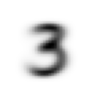

In [16]:
# compute average image for each class
mean3 = stacked_threes.mean(axis=0)
show_image(mean3)

<AxesSubplot:>

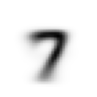

In [17]:
mean7 = stacked_sevens.mean(axis=0)
show_image(mean7)

Let's take a random "3" image and the compute its similarity with mean images.

In [18]:
a_3 = stacked_threes[42]

# we can use absolute mean of differences
dist_3_abs = (a_3 - mean3).abs().mean()
# or we can use RMSE - or root mean squared error
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

# print both of them
dist_3_abs, dist_3_sqr

(tensor(0.1210), tensor(0.2216))

In [19]:
# not let's compare with the mean7

dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqrt = ((a_3 - mean7)**2).mean().sqrt()

dist_7_abs, dist_7_sqrt

(tensor(0.1769), tensor(0.3294))

the distances are lower when comparing with mean3, so we can conclude the selected image is a 3.

In [20]:
# we can use in-built functions by PyTorch to compute those distances
from torch.nn import functional as F

In [21]:
# mean absolute difference, also know as F1 norm
F.l1_loss(a_3.float(), mean3)

tensor(0.1210)

In [22]:
# the RMSE
F.mse_loss(a_3, mean3).sqrt()

tensor(0.2216)

### Get a metric for our baseline model based on pixel similarity

In [23]:
# Create stack of tensors for each image from the validation dataset

valid_3_tensors = torch.stack([
    tensor(Image.open(o)) for o in (path/"valid"/"3").ls()
]).float() / 255

valid_7_tensors = torch.stack([
    tensor(Image.open(o)) for o in (path/"valid"/"7").ls()
]).float() / 255

valid_3_tensors.shape, valid_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
def mnist_distance(a, b):
    """This computes mean absolute error, if a or b are tensors, then PyTorch
    performs broadcasting."""
    # mean is computed in the two dimensions of images, they are the last ones.
    return (a-b).abs().mean((-1, -2))

In [25]:
def is_3(x):
    """Return boolean tensor, when the mnist_distance is less for mean3 then is a 3."""
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [26]:
# test
label = is_3(a_3)
# we can convert to float, to calculate accuracy
label, label.float()

(tensor(True), tensor(1.))

In [27]:
# Calculate the final accuracy as an average of the two classes
acc_3s = is_3(valid_3_tensors).float().mean()
acc_7s = (1 - is_3(valid_7_tensors).float()).mean()

print(acc_3s, acc_7s)
print("Accuracy of the baseline model", (acc_3s + acc_7s) / 2)

tensor(0.9168) tensor(0.9854)
Accuracy of the baseline model tensor(0.9511)


## The MNIST Loss Function

### Create dataset as PyTorch tensors

In [28]:
"""We use view() to change the from a list of matrices (a rank-3 tensor) to a list of 
flattened matrices, i.e. vectors. -1 means "makes this axis as big as necessary to fit
all the data.
"""
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
# then we need to create the labels, where 1 is for "three"'s and 0 for "seven"'s
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(dim=1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [29]:
# create train dataset
train_dataset = list(zip(train_x, train_y))
x_i, y_i = train_dataset[0]

x_i.shape, y_i

(torch.Size([784]), tensor([1]))

In [30]:
# We do the same to create the validation dataset
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(dim=1)
valid_dataset = list(zip(valid_x, valid_y))

len(valid_dataset), len(valid_dataset[0])

(2038, 2)

In [31]:
def init_params(size: tuple, std=1.0):
    return (torch.rand(size)*std).requires_grad_()

In [32]:
weights = init_params((28*28, 1)) # a vector (28*28, 1)
bias = init_params(1)

In [33]:
# linear operation, dot product -> matrix multiplication
def linear_1(image_x):
    return image_x@weights + bias

Note

In recent versions of Python 3, it can be used as an operator in expressions. It was added to allow a simple operator for matrix multiplication. (Interestingly, Python does not have a built-in matrix class, so if you are just using Python without importing anything, you can’t use this operator! But there are math libraries that define matrix types, and those types implement the special method functions to make @ work

src: https://qr.ae/pyXol4

In [34]:
preds = linear_1(train_x)
preds

tensor([[49.1828],
        [53.0565],
        [51.7499],
        ...,
        [45.9112],
        [44.8076],
        [37.9669]], grad_fn=<AddBackward0>)

In [35]:
# we can check the right predictions, creating labels and comparing with train_y
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [36]:
acc = corrects.float().mean() 
acc

tensor(0.4946)

**We need gradients to be able to update the weights and for that we need a loss function**

Can we use the accuracy metric as the loss function?

No. There's a problem...accuracy is a (non-smooth) function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. We can use a **sigmoid function**.

We want that when loss functions receives more right predictions the return value is a lower number, and when they're wrong we get higher values.

In [37]:
def plot_function(f, title=None, min=-2.1, max=2.1, color="g", ylim=None):
    x = torch.linspace(min, max, 100)[:, None]

    if ylim:
        plt.ylim(ylim)
    
    plt.plot(x, f(x), color)
    if title:
        plt.title(label=title)

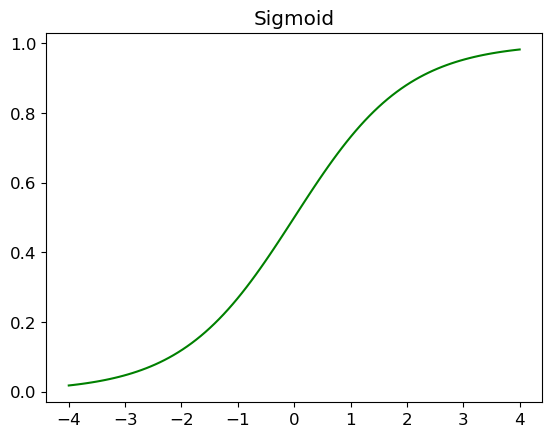

In [38]:
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

In [39]:
def sigmoid(x):
    # btw, we can use in-built sigmoid fn by PyTorch
    return 1 / (1 + torch.exp(-x))

In [40]:
# so we can use the next function, where predictions are always between 0 and 1 because
# sigmoid were applied to them.
def mnist_loss(preds, targets):
    """torch.where(a,b,c). This is the same as running the list comprehension 
    [b[i] if a[i] else c[i] for i in range(len(a))]

    if targets is equal to 1, then return 1 - pred (it will be lower if it's right the prediction)
    other case, return the prediction, meaning that was expected a 0.
    """
    preds.sigmoid()
    return torch.where(condition=targets==1, input=1-preds, other=preds).mean()

The metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. 

## Stochastic Gradient Descent (SGD) and Mini-Batches

We can update the weights after process one single input forward, but this will be so inestable, the other option is to process the whole dataset, get an average loss and then update the weights and bias, so there's a trade-off, in practice we take a batch to do backpropagation.

In [41]:
# A data loader helps us to create batches from a collection (like a dataset), example
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [42]:
# A dataset tipically has the independent variables and the dependent one
import string

little_dataset = list(enumerate(string.ascii_lowercase))
little_dataset[:5]

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e')]

In [43]:
dl = DataLoader(little_dataset, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting it all together

In [66]:
# Create data loader from MNIST dataset
dataloader = DataLoader(dataset=train_dataset, batch_size=256)

xbatch, ybatch = first(dataloader)

xbatch.shape, ybatch.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [67]:
# the same for the validation dataset
dataloader_valid = DataLoader(dataset=valid_dataset, batch_size=256)

type(dataloader_valid)

fastai.data.load.DataLoader

### Training using our own functions and methods

In [46]:
# re-initialize params
weights = init_params((28*28,1))
bias = init_params(1)

In [47]:
# linear operation, dot product -> matrix multiplication
def linear_1(image_x):
    return image_x@weights + bias

In [48]:
def calc_grad(xb, yb, model):
    """Forward and compute the gradient for a single batch"""
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [49]:
def train_epoch(model, lr, params):
    """Calculate gradient for each batch of the data loader."""
    for xb, yb in dataloader:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            # this important to reset gradient in-place, to not affect the next iteration
            # since PyTorch keep stores the gradient.
            p.grad.zero_()

In [50]:
def batch_accuracy(x_batch, y_batch, threshold=0.5):
    """Compute the average accuracy for a sigle batch"""
    preds = x_batch.sigmoid() # make sure everything is between 0 and 1
    correct = (preds > threshold) == y_batch

    return correct.float().mean()


In [51]:
def validate_epoch(model):
    """Compute accuracy usign the validation dataset"""
    accs = [batch_accuracy(model(xb), yb) for xb, yb in dataloader_valid]

    return round(torch.stack(accs).mean().item(), 4)

In [52]:
# train for a few epochs
NUM_EPOCHS = 20
LEARNING_RATE = 0.1
params = (weights, bias)

for epoch in range(NUM_EPOCHS):
    train_epoch(linear_1, lr=LEARNING_RATE, params=params)
    print(validate_epoch(linear_1))

0.5228
0.8056
0.88
0.9091
0.9234
0.9353
0.9392
0.9417
0.9442
0.9447
0.9466
0.9486
0.9491
0.9491
0.9496
0.9506
0.9511
0.9521
0.9526
0.9526


### Training using an optimizer

In [68]:
## nn.Linear does the same thing as our init_params and linear functions together.
# It contains both the weights and biases in a single class.
from torch import nn

In [138]:
linear_model = nn.Linear(
    in_features=28*28, out_features=1, bias=True
)

w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [139]:
class BasicOptimizer:
    def __init__(self, params, lr: float):
        self.params = list(params)
        self.lr = lr
    
    def step(self, *args, **kwargs):
        for param in self.params:
            param.data -= param.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for param in self.params:
            param.grad = None

In [140]:
optimizer = BasicOptimizer(linear_model.parameters(), 0.001)

In [141]:
# update the training loop
def train_epoch(model):
    for xb, yb in dataloader:
        calc_grad(xb, yb, model)
        optimizer.step()
        optimizer.zero_grad()

In [142]:
def fit(model, epochs):
    for epoch in range(epochs):
        train_epoch(model)
        print(f"epoch: {epoch},", validate_epoch(model))

In [143]:
fit(linear_model, epochs=20)

epoch: 0, 0.9201
epoch: 1, 0.9502
epoch: 2, 0.9561
epoch: 3, 0.9581
epoch: 4, 0.9576
epoch: 5, 0.9571
epoch: 6, 0.9571
epoch: 7, 0.9566
epoch: 8, 0.9551
epoch: 9, 0.9541
epoch: 10, 0.9541
epoch: 11, 0.9546
epoch: 12, 0.9541
epoch: 13, 0.9541
epoch: 14, 0.9541
epoch: 15, 0.9541
epoch: 16, 0.9541
epoch: 17, 0.9541
epoch: 18, 0.9541
epoch: 19, 0.9541


**We can use the Optimizer by fastai**

In [150]:
linear_model = nn.Linear(28*28, 1)
optimizer = SGD(linear_model.parameters(), lr=0.0001)

fit(linear_model, 20)

epoch: 0, 0.4149
epoch: 1, 0.5003
epoch: 2, 0.5823
epoch: 3, 0.6567
epoch: 4, 0.7242
epoch: 5, 0.7874
epoch: 6, 0.8369
epoch: 7, 0.8726
epoch: 8, 0.9039
epoch: 9, 0.92
epoch: 10, 0.9303
epoch: 11, 0.9381
epoch: 12, 0.9425
epoch: 13, 0.9454
epoch: 14, 0.9493
epoch: 15, 0.9508
epoch: 16, 0.9522
epoch: 17, 0.9537
epoch: 18, 0.9551
epoch: 19, 0.9561


In [156]:
# We can use a Learner (instead of fit function) and DataLoaders by fastai
data_loaders = DataLoaders(dataloader, dataloader_valid)

learner = Learner(
    data_loaders,
    model=nn.Linear(28*28, 1),
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy,
)

In [162]:
learner.fit(NUM_EPOCHS, lr=0.0001)

## Adding a non-linearity

To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

In [165]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [166]:
def simple_net(xb): 
    res = xb@w1 + b1
    # ReLU
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions.

In [185]:
# or we can use PyTorch class Sequential to define a NN with a non-linear activation fn

simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
)

In [188]:
learn = Learner(
    data_loaders,
    simple_net,
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy
)

learn.fit(20, 0.001)

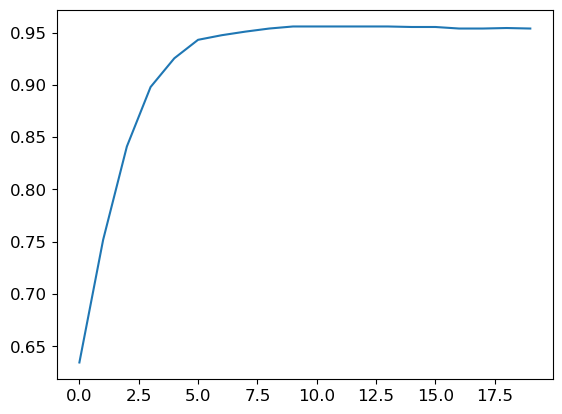

In [189]:
plt.plot(L(learn.recorder.values).itemgot(2))


In [190]:
# final accuracy
learn.recorder.values[-1][2]


0.9538763761520386